In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv("./combine_2010_2025")


In [6]:
df = df[df["Pos"].isin(["WR", "CB", "RB", "FS", "OLB", "ILB", "SS", "TE"])]

In [ ]:

data = df[["Vertical", "Ht", "40yd"]]
data = data.dropna()
scaler = StandardScaler()


In [ ]:
X, y = data.drop(["40yd"], axis="columns"), data["40yd"]
X_train, X_test, y_train, y_test = train_test_split(scaler.fit_transform(X), y, test_size=0.2)

,Vertical,Ht,40yd
0,36.0,75.0,4.60
7,35.0,72.0,4.71
10,40.0,74.0,4.52
14,31.0,67.0,4.37
17,39.5,75.0,4.89
...,...,...,...
5374,31.0,75.0,4.56
5377,32.0,70.0,4.46
5380,36.5,71.0,4.40
5382,33.5,72.0,4.50


In [ ]:
models = {}

In [ ]:



rf = GridSearchCV(RandomForestRegressor(), {
    "n_estimators": [1, 10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None],
})

rf.fit(X_train, y_train)
models["RandomForestRegressor"] = rf

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [2, 3, ...], 'n_estimators': [1, 10, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [ ]:
et = GridSearchCV(ExtraTreesRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],    
    "max_depth": [2, 3, 4, 5, 7, 10, None],
})

et.fit(X_train, y_train)
models["ExtraTreesRegressor"] = et

,estimator,ExtraTreesRegressor()
,param_grid,"{'max_depth': [2, 3, ...], 'n_estimators': [10, 50, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [ ]:
xgb = GridSearchCV(XGBRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None],
})

xgb.fit(X_train, y_train)
models["XGBRegressor"] = xgb

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'max_depth': [2, 3, ...], 'n_estimators': [10, 50, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [ ]:
xrf = GridSearchCV(XGBRFRegressor(), {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": [2, 3, 4, 5, 7, 10, None]
})

xrf.fit(X_train, y_train)
models["XGBRFRegressor"] = xrf

,estimator,"XGBRFRegresso...ate=None, ...)"
,param_grid,"{'max_depth': [2, 3, ...], 'n_estimators': [10, 50, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,learning_rate,1.0


In [ ]:




mlp = GridSearchCV(MLPRegressor(), {
    ""
    "max_iter": [10000],
    "solver": ["lbfgs", "adam"],
    "hidden_layer_sizes": [(100, 50, 20), (200, 100, 40), (500, 200, 100, 50), (600, 500, 200, 100, 50), (500, 400, 300, 210, 160, 120, 80, 50)]
})

mlp.fit(X_train, y_train)
models["MLPRegressor"] = mlp


,estimator,MLPRegressor()
,param_grid,"{'hidden_layer_sizes': [(100, ...), (200, ...), ...], 'max_iter': [10000], 'solver': ['lbfgs', 'adam']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [ ]:
from sklearn.metrics import mean_squared_error

for k, v in results.items():
    print(k.ljust(30) + str(v))

for key, model in models.itemes():
    mse = mean_squared_error(y_test, model.predict(X_test))
    r_score = 1 - mse / var
    print(key.ljust(30) + str(r_score))

RandomForestRegressor         0.658616701974847
ExtraTreesRegressor           0.6715756453412182
XGBRFRegressor                0.667049581902441
XGBRegressor                  0.6647537054271644
MLPRegressor                  0.6528090225673547


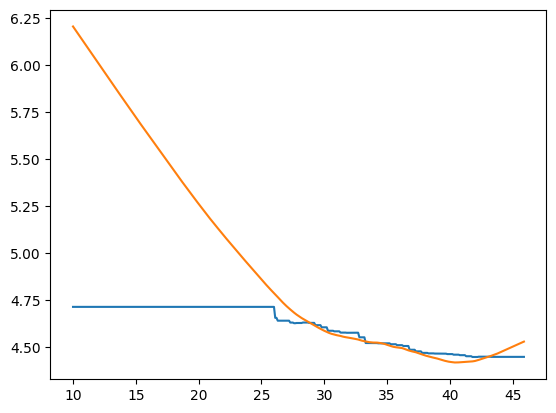

In [ ]:

vertical = list(np.arange(10, 46, 0.1))
my_data = pd.DataFrame({
    "Vertical": vertical,
    "Ht": [70] * len(vertical),
})
my_data = scaler.transform(my_data)

for key, model in models.items():
    prediction = model.predict(my_data)
    plt.plot(vertical, prediction, label=key)

plt.legend()
plt.show()

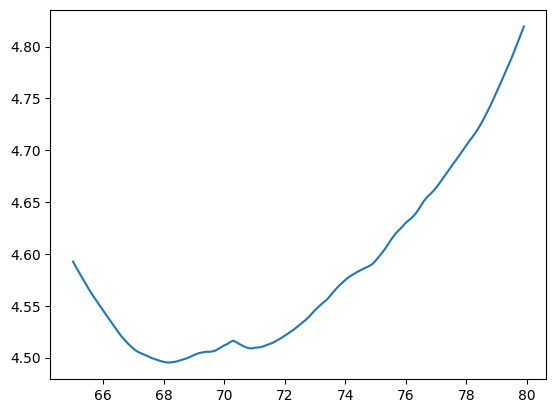

In [ ]:
model = mlp
ht = list(np.arange(65, 80, 0.1))
my_data = pd.DataFrame({
    "Vertical": [35] * len(ht),
    "Ht": ht,
})
for key, model in models.items():
    my_data = scaler.transform(my_data)
    prediction = model.predict(my_data)
    plt.plot(ht, prediction, label=key)

plt.legend()
plt.show()

In [ ]:
import pickle

with open("models.pickle", "wb") as file:
    pickle.dump(models, file)